# ***Theme of This Project***
This project predicts whether a telecom/e-commerce customer will churn (leave) using historical customer usage and account data. The pipeline begins with raw CSV data ingestion, cleaning and feature engineering (handling missing values, encoding categorical variables, scaling numeric features), followed by exploratory data analysis (to understand feature distributions and class imbalance). Several supervised models (Random Forest, Gradient Boosting, and an artificial neural network) are trained and tuned. Models are evaluated with metrics appropriate for imbalanced classification (precision, recall, F1, ROC-AUC, PR-AUC). The best performing model is saved and documented for deployment; visualization and model interpretation (feature importances, ROC, confusion matrix) support business decisions to reduce churn.

# ***Step-by-step process***

Data acquisition

Load the CSV (e.g., WA_Fn-UseC_-Telco-Customer-Churn.csv) from Drive or Colab upload.

Initial inspection

df.head(), df.info(), df.describe(), df.isnull().sum() to find missing values and types.

Cleaning & missing value handling

Impute numeric missing values (median/mean) and categorical (mode or new category “Unknown”).

Fix inconsistent strings (e.g., trim spaces, unify case).

Feature engineering

Create meaningful features (e.g., avg_day_charge = total_day_charge / total_day_minutes), bin continuous features if useful, combine or drop redundant columns (IDs).

Categorical encoding

For ordinal categories use OrdinalEncoder; for nominal use OneHotEncoder or target encoding if many categories.

Scaling

Apply StandardScaler or MinMaxScaler to numeric features (especially for ANN).

Train/test split & resampling

train_test_split (e.g., 80/20). Handle class imbalance with class_weight or oversampling (SMOTE) on the training set only.

Model training

Train Random Forest, Gradient Boosting (XGBoost/LightGBM/CatBoost), and a simple ANN. Use cross-validation and hyperparameter search (GridSearchCV/RandomizedSearchCV).

Evaluation

Use accuracy, precision, recall, F1, ROC-AUC, PR-AUC. Plot confusion matrix & ROC. Prefer recall/precision depending on business cost of false negatives/positives.

Importing all the neccesary packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf # Works as a connector between the pandas library and plotly
cf.go_offline()
from sklearn.model_selection import GridSearchCV

Reading DataSet

In [2]:
df = pd.read_csv('/content/telecom_churn.csv')
df.head(5)

,state,account_length,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,class
0,16,128,415,2845,0,1,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,35,107,415,2301,0,1,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,31,137,415,1616,0,0,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,35,84,408,2510,1,0,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,36,75,415,155,1,0,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


DataSet Info

In [4]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   state                          5000 non-null   int64  
 1   account_length                 5000 non-null   int64  
 2   area_code                      5000 non-null   int64  
 3   phone_number                   5000 non-null   int64  
 4   international_plan             5000 non-null   int64  
 5   voice_mail_plan                5000 non-null   int64  
 6   number_vmail_messages          5000 non-null   int64  
 7   total_day_minutes              5000 non-null   float64
 8   total_day_calls                5000 non-null   int64  
 9   total_day_charge               5000 non-null   float64
 10  total_eve_minutes              5000 non-null   float64
 11  total_eve_calls                5000 non-null   int64  
 12  total_eve_charge               5000 non-null   f

,state,account_length,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,class
count,5000.00000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,25.99840,100.25860,436.911400,2499.500000,0.094600,0.264600,7.755200,180.288900,100.029400,30.649668,...,100.191000,17.054322,200.391620,99.919200,9.017732,10.261780,4.435200,2.771196,1.570400,0.141400
std,14.80348,39.69456,42.209182,1443.520003,0.292691,0.441164,13.546393,53.894699,19.831197,9.162069,...,19.826496,4.296843,50.527789,19.958686,2.273763,2.761396,2.456788,0.745514,1.306363,0.348469
min,0.00000,1.00000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,13.00000,73.00000,408.000000,1249.750000,0.000000,0.000000,0.000000,143.700000,87.000000,24.430000,...,87.000000,14.140000,166.900000,87.000000,7.510000,8.500000,3.000000,2.300000,1.000000,0.000000
50%,26.00000,100.00000,415.000000,2499.500000,0.000000,0.000000,0.000000,180.100000,100.000000,30.620000,...,100.000000,17.090000,200.400000,100.000000,9.020000,10.300000,4.000000,2.780000,1.000000,0.000000
75%,39.00000,127.00000,415.000000,3749.250000,0.000000,1.000000,17.000000,216.200000,113.000000,36.750000,...,114.000000,19.900000,234.700000,113.000000,10.560000,12.000000,6.000000,3.240000,2.000000,0.000000
max,50.00000,243.00000,510.000000,4999.000000,1.000000,1.000000,52.000000,351.500000,165.000000,59.760000,...,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000,1.000000


Visual represtation of dataset(Histogram)

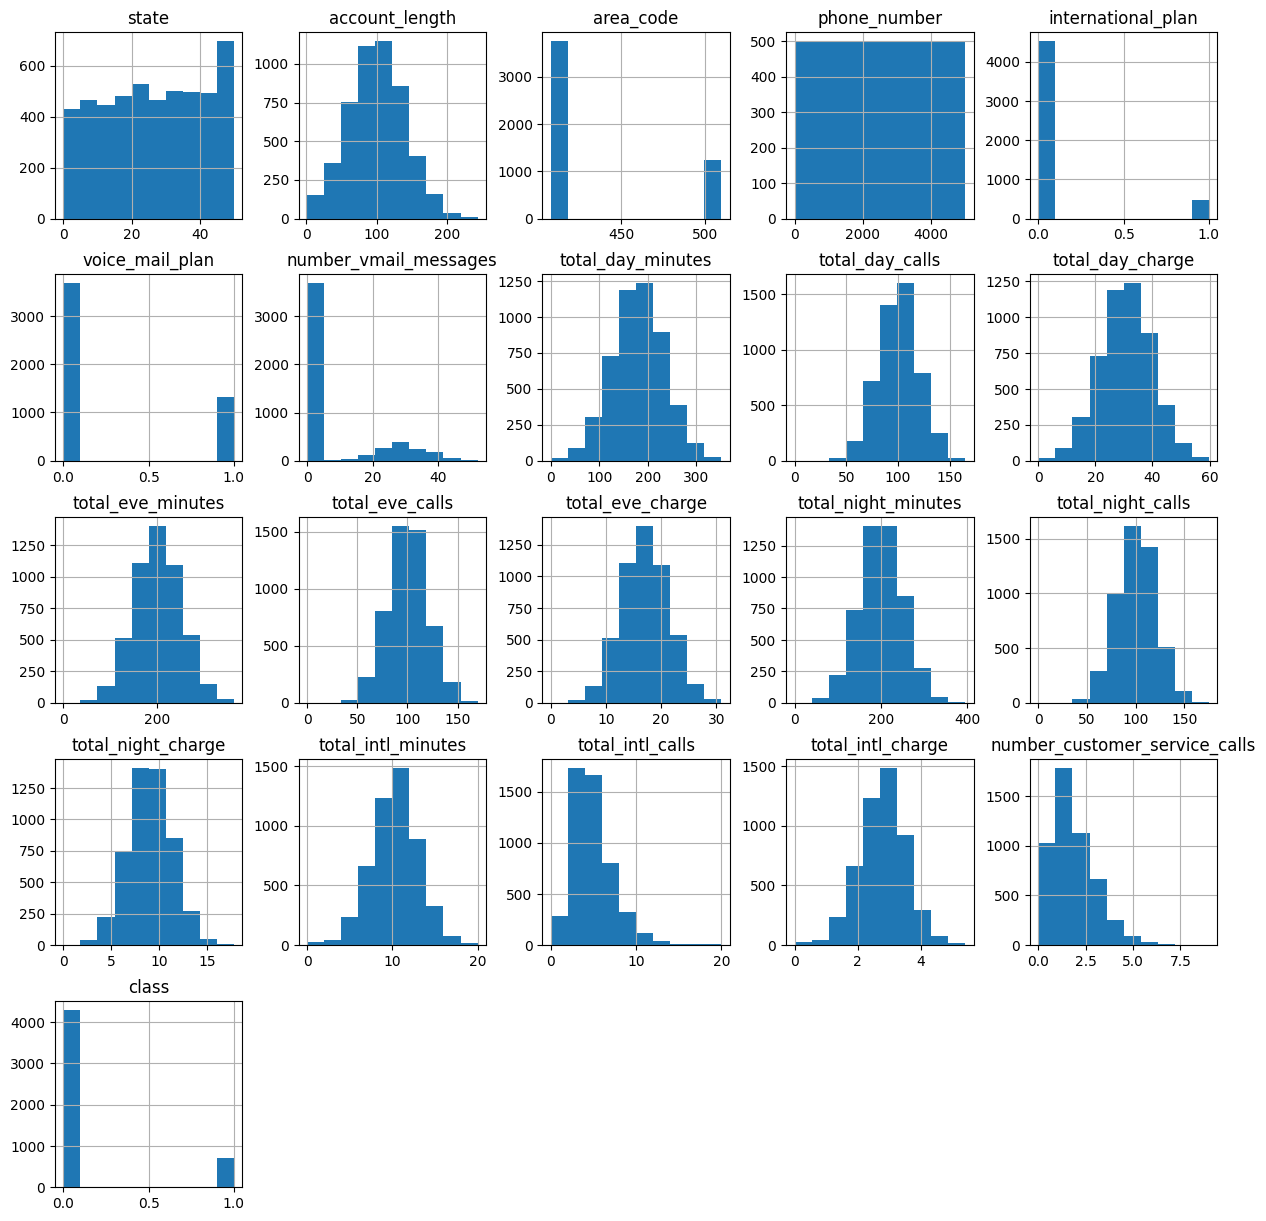

In [5]:
df.hist(figsize=(15,15))
plt.show()

Visual reapresentaion of Dataset(Pie chart)

---



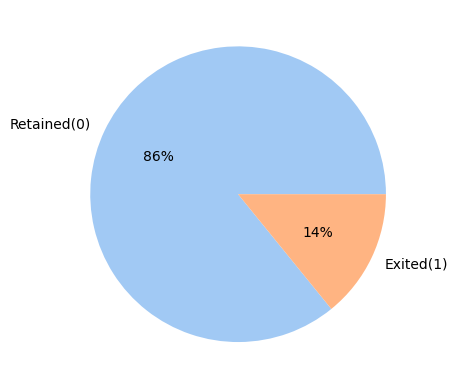

In [6]:
colors = sns.color_palette('pastel')[0:5]
plt.pie(df['class'].value_counts(), labels = ['Retained(0)', 'Exited(1)'], colors = colors, autopct='%.0f%%')
plt.show()

Visual reapresentaion of Dataset(HeatMap)

---



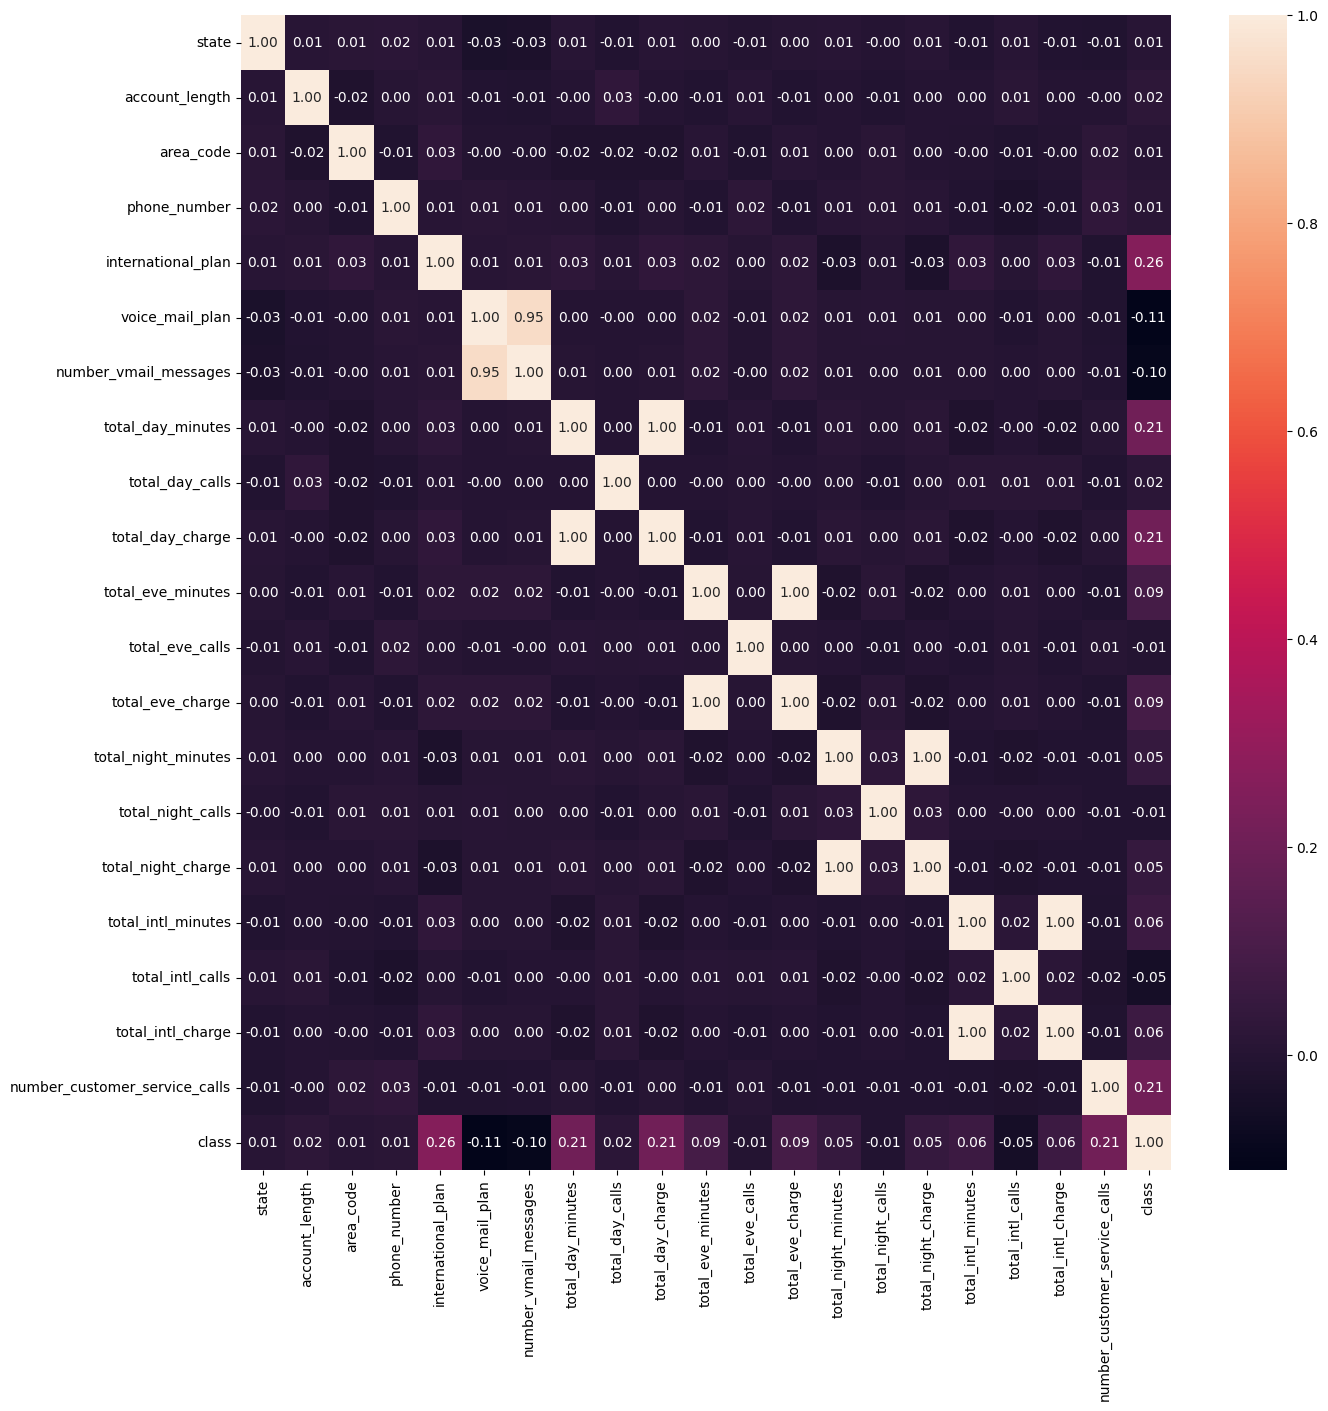

In [7]:
corr_matrix = df.corr()
plt.figure(figsize = (15,15))
sns.heatmap(corr_matrix, annot = True, fmt = '0.2f')
plt.show()

day_charges_churn_distribution(Kernel Density Estimate (KDE) plot)

/tmp/ipython-input-3303476346.py:2: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


/tmp/ipython-input-3303476346.py:4: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




Text(0.5, 1.0, 'Distribution of day charges by churn')

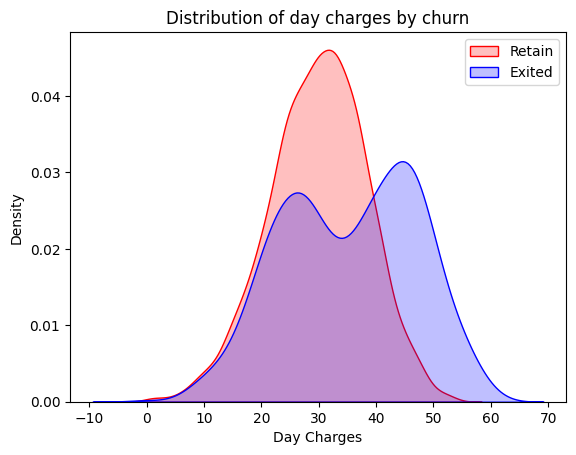

In [8]:
# Churn by day charges
ax = sns.kdeplot(df.total_day_charge[(df["class"] == 0)],
               color = "Red", shade = True)
ax = sns.kdeplot(df.total_day_charge[(df["class"] == 1)],
               color = "Blue", shade = True)

ax.legend(["Retain", "Exited"], loc = "upper right")
ax.set_ylabel("Density")
ax.set_xlabel("Day Charges")
ax.set_title("Distribution of day charges by churn")

“Comparative KDE Distribution Plot” for evening charges.

/tmp/ipython-input-601002929.py:2: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


/tmp/ipython-input-601002929.py:4: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




Text(0.5, 1.0, 'Distribution of evening charges by churn')

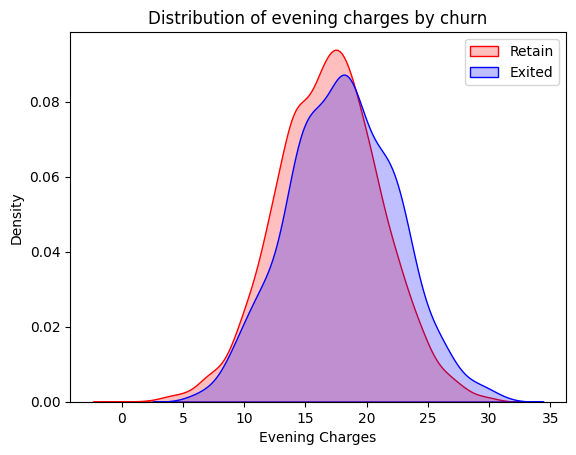

In [9]:
# Churn by evening charges
ax = sns.kdeplot(df.total_eve_charge[(df["class"] == 0)],
               color = "Red", shade = True)
ax = sns.kdeplot(df.total_eve_charge[(df["class"] == 1)],
               color = "Blue", shade = True)

ax.legend(["Retain", "Exited"], loc = "upper right")
ax.set_ylabel("Density")
ax.set_xlabel("Evening Charges")
ax.set_title("Distribution of evening charges by churn")

**Telecom Churn Prediction : Data Preprocessing**

In [10]:
X = df.drop(['class', 'area_code', 'phone_number'], axis='columns')
Y = df['class']

In [11]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

In [12]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier()
RF.fit(x_train,y_train)


RandomForestClassifier()

**Telecom Churn Prediction : Feature Selection**

In [13]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier()
RF.fit(x_train,y_train)


RandomForestClassifier()

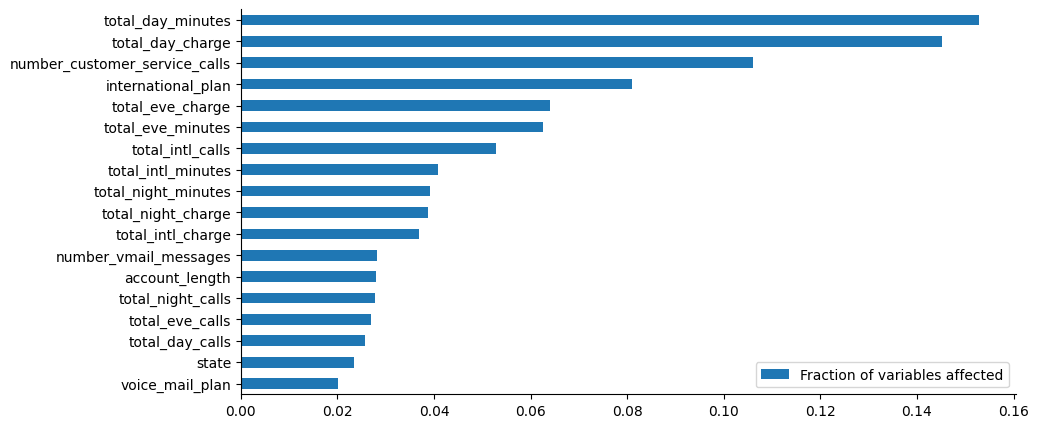

In [14]:
# Plot the feature importance
feature_scores= pd.DataFrame({"Fraction of variables affected" : RF.feature_importances_},index = X.columns)
feature_scores= feature_scores.sort_values(by = "Fraction of variables affected")
feature_scores.plot(kind = "barh", figsize = (10, 5))
sns.despine()

**Telecom Churn Prediction : Model Evaluation**

**- Logistic Regression**

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

Grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
LR_Model = LogisticRegression()
LR_Model_CV=GridSearchCV(LR_Model,Grid,cv=10)

LR_Model_CV.fit(x_train, y_train)

print("tuned hpyerparameters :(best parameters) ",LR_Model_CV.best_params_)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.12/dist-packages/sklearn/

tuned hpyerparameters :(best parameters)  {'C': np.float64(0.001), 'penalty': 'l2'}


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.12/dist-packages/sklearn/

In [16]:
LR_Model = LogisticRegression(C=0.001, penalty="l2")
LR_Model.fit(x_train, y_train)


y_pred = LR_Model.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92       841
           1       0.88      0.04      0.08       159

    accuracy                           0.85      1000
   macro avg       0.86      0.52      0.50      1000
weighted avg       0.85      0.85      0.78      1000



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



<Axes: >

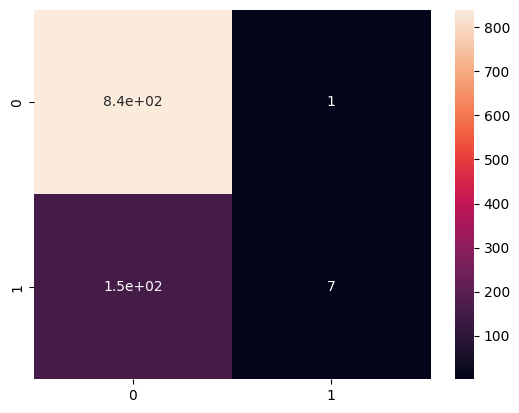

In [17]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True)

**Telecom Churn Prediction : Model Evaluation**

**- Support Vector Machine**

In [18]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC

SVM_Model = LinearSVC(max_iter = 10000)
SVM_Model = CalibratedClassifierCV()
SVM_Model.fit(x_train, y_train)

CalibratedClassifierCV()

In [19]:
y_pred = SVM_Model.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.97      0.91       841
           1       0.49      0.16      0.24       159

    accuracy                           0.84      1000
   macro avg       0.67      0.56      0.57      1000
weighted avg       0.80      0.84      0.80      1000



<Axes: >

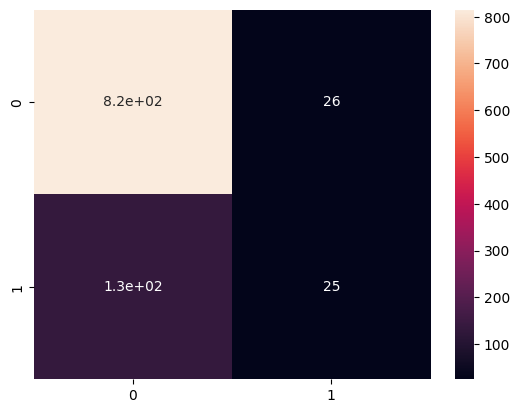

In [20]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True)

**Telecom Churn Prediction : Model Evaluation**

**- Random Forest Classifier**

In [21]:
from sklearn.ensemble import RandomForestClassifier

RF_Model = RandomForestClassifier()
RF_Model.fit(x_train, y_train)

RandomForestClassifier()

In [22]:
y_pred = RF_Model.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       841
           1       0.92      0.74      0.82       159

    accuracy                           0.95      1000
   macro avg       0.94      0.86      0.89      1000
weighted avg       0.95      0.95      0.95      1000



<Axes: >

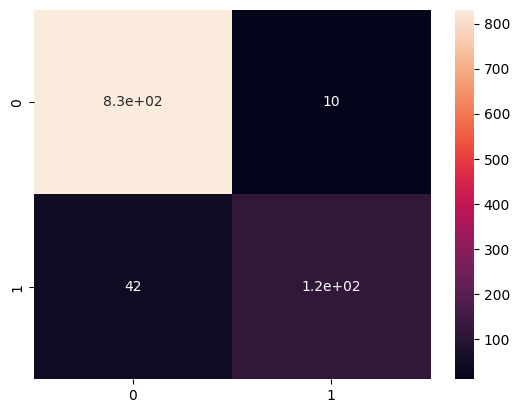

In [23]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True)

**Telecom Churn Prediction : Model Evaluation**

**- K-Nearest Neighbour**

In [24]:
from sklearn.neighbors import KNeighborsClassifier

KNN = KNeighborsClassifier()
k_range = list(range(1, 31))
param_grid = dict(n_neighbors=k_range)

# defining parameter range
grid = GridSearchCV(KNN, param_grid, cv=10, scoring='accuracy', return_train_score=False,verbose=1)

# fitting the model for grid search
grid_search=grid.fit(x_train, y_train)

print(grid_search.best_params_)

Fitting 10 folds for each of 30 candidates, totalling 300 fits
{'n_neighbors': 7}


In [25]:
KNN_Model = KNeighborsClassifier(n_neighbors=6)
KNN_Model.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=6)

In [26]:
y_pred = KNN_Model.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.99      0.92       841
           1       0.83      0.18      0.30       159

    accuracy                           0.86      1000
   macro avg       0.85      0.59      0.61      1000
weighted avg       0.86      0.86      0.83      1000



<Axes: >

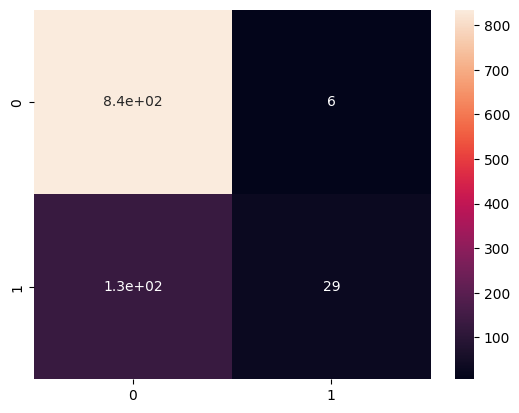

In [27]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True)

**Telecom Churn Prediction : Model Evaluation**

**- Naive Bayes Classifier**

In [29]:
from sklearn.naive_bayes import GaussianNB

GNB_Model = GaussianNB()
GNB_Model.fit(x_train, y_train)

GaussianNB()

In [30]:
y_pred = GNB_Model.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       841
           1       0.53      0.45      0.49       159

    accuracy                           0.85      1000
   macro avg       0.71      0.69      0.70      1000
weighted avg       0.84      0.85      0.84      1000



<Axes: >

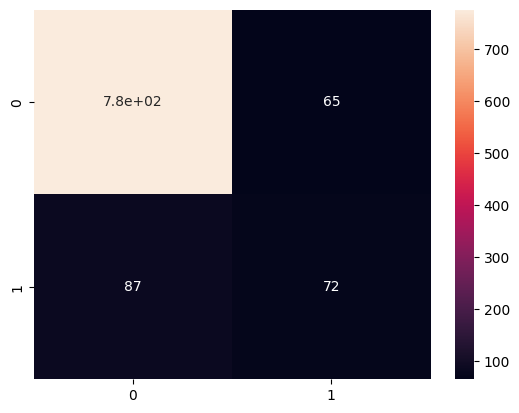

In [31]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True)

**Comparing Models**

In [32]:
# ROC curve
from sklearn.metrics import roc_curve

fpr1, tpr1, thresh1 = roc_curve(y_test, LR_Model.predict_proba(x_test)[:, 1], pos_label = 1)
fpr2, tpr2, thresh2 = roc_curve(y_test, SVM_Model.predict_proba(x_test)[:, 1], pos_label = 1)
fpr3, tpr3, thresh3 = roc_curve(y_test, RF_Model.predict_proba(x_test)[:, 1], pos_label = 1)
fpr4, tpr4, thresh4 = roc_curve(y_test, KNN_Model.predict_proba(x_test)[:, 1], pos_label = 1)
fpr5, tpr5, thresh5 = roc_curve(y_test, GNB_Model.predict_proba(x_test)[:, 1], pos_label = 1)

In [33]:
# AUC score
from sklearn.metrics import roc_auc_score

auc_score1 = roc_auc_score(y_test, LR_Model.predict_proba(x_test)[:, 1])
auc_score2 = roc_auc_score(y_test, SVM_Model.predict_proba(x_test)[:, 1])
auc_score3 = roc_auc_score(y_test, RF_Model.predict_proba(x_test)[:, 1])
auc_score4 = roc_auc_score(y_test, KNN_Model.predict_proba(x_test)[:, 1])
auc_score5 = roc_auc_score(y_test, GNB_Model.predict_proba(x_test)[:, 1])

print("Logistic Regression: ", auc_score1) # Logistic Regression
print("Support Vector Machine: ", auc_score2) # Support Vector Machine
print("Random Forest: ", auc_score3) # Random Forest
print("K-Nearest Neighbors: ", auc_score4) # K-Nearest Neighbors
print("Naive Bayes: ", auc_score5) # Naive Bayes

Logistic Regression:  0.6371271098348028
Support Vector Machine:  0.7996395426229631
Random Forest:  0.9149672073527324
K-Nearest Neighbors:  0.6542824879037386
Naive Bayes:  0.8177521519006274


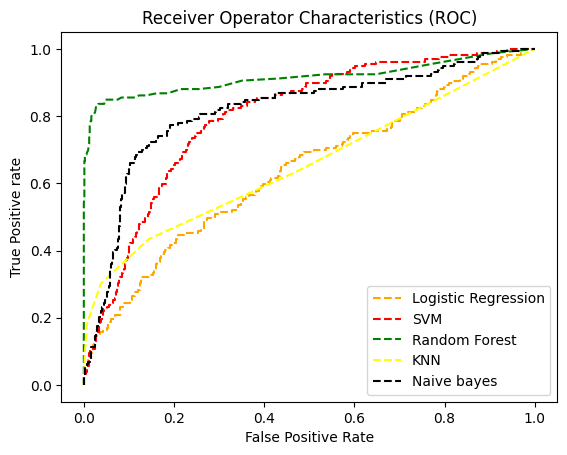

In [34]:
plt.plot(fpr1, tpr1, linestyle = "--", color = "orange", label = "Logistic Regression")
plt.plot(fpr2, tpr2, linestyle = "--", color = "red", label = "SVM")
plt.plot(fpr3, tpr3, linestyle = "--", color = "green", label = "Random Forest")
plt.plot(fpr4, tpr4, linestyle = "--", color = "yellow", label = "KNN")
plt.plot(fpr5, tpr5, linestyle = "--", color = "black", label = "Naive bayes")

plt.title('Receiver Operator Characteristics (ROC)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')

plt.legend(loc = 'best')
plt.savefig('ROC', dpi = 300)
plt.show()

# ***Models used***
***Random Forest***

What it is: Ensemble of decision trees using bagging; robust to noise and needs little scaling.

Why use it: Good baseline, handles mixed data types, interpretable with feature importances.

Tune: n_estimators, max_depth, min_samples_split, max_features.

Pros/Cons: Fast to train for moderate sized data; can overfit if not tuned. Works well with imbalanced data if class_weight='balanced'.

***Gradient Boosting (XGBoost / LightGBM / CatBoost)***

What it is: Boosted trees that sequentially fix prior errors — often top performer on tabular data.

Why use it: High predictive power, handles missing values (CatBoost/LightGBM) and categorical data (CatBoost).

Tune: learning_rate, n_estimators, max_depth, subsample, colsample_bytree.

Pros/Cons: Usually better accuracy than RF but needs more careful tuning and longer training time.

Artificial Neural Network (ANN) **bold text** *italicized text*

What it is: Feedforward MLP or shallow NN built with TensorFlow/Keras or PyTorch.

Why use it: Flexible; useful if you create many numeric features or combine with embeddings for high-cardinality categorical variables.

Architecture tips: Start simple — e.g., Dense(64) → Dense(32) → Dense(1, sigmoid). Use dropout, batchnorm, early stopping.

Tune: number of layers, neurons, dropout rate, batch size, learning rate.

Pros/Cons: May need more data & tuning; less interpretable than tree models.



## Plots used
KDE plot — distribution by churn (day/evening/night charges)
***bold text***
What it is: Kernel Density Estimate (smoothed distribution).

Why use it: Compare distributions of continuous features across churn vs. retain groups.

Interpretation: Overlap means similar behavior; separation suggests predictive power.


Histogram (single variable distributions) ***bold text***

What it is: Counts per bin for a numeric variable.

Why use it: See skewness, multi-modality, or outliers.

When to use: Before/after log transforms or binning.

***Boxplot (numeric vs churn)***

What it is: Shows median, IQR, and outliers.

Why use it: Compare median and spread across churn groups (detect outliers).

***Correlation heatmap***

What it is: Pearson (or Spearman) correlations between numeric features.

Why use it: Identify highly correlated or redundant features for removal or PCA.

Countplot / Bar chart (categorical distributions)

What it is: Frequency of categories split by churn.

Why use it: Identify categorical levels associated with churn (e.g., contract type).

***Feature importance plot (tree models)***

What it is: Importance score per feature from RF/XGBoost.

Why use it: Understand which features contribute most to prediction; help business take action.

Confusion matrix & classification report

What it is: True vs predicted class matrix + precision/recall/f1.

Why use it: Understand types of errors; important for business risk analysis.

***ROC Curve & AUC***

What it is: True positive rate vs false positive rate across thresholds.

Why use it: Overall discrimination ability of model; AUC is threshold-independent metric.

***Precision-Recall Curve & PR-AUC***

What it is: Precision vs recall at different thresholds.

Why use it: Preferable when data is imbalanced (churn typically is).



# ***Project value (Learning curve)***

What it is: Train and validation score as function of training set size.

Why use it: Diagnose high bias vs high variance and whether more data helps.

SHAP / Partial Dependence Plots (interpretability)

What it is: Explain model predictions (global & local).

Why use it: Show how a feature influences predicted churn probability — useful for stakeholders.